In [15]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from IPython.display import display
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
shap.initjs()



In [16]:
#EASY CLEANING PAIRS
COL_UNIT_PAIRS = {'process_size': 'nm',
 'transistors': 'million',
 'die_size': 'mm²',
 'base_clock': 'MHz',
 'memory_bus': 'bit',
 'tdp' : 'W',
 'memory_clock': 'MHz',
 'pixel_rate': 'GPixel/s',
 'texture_rate': 'GTexel/s',}

### PULL DATA FROM CSV

In [17]:
#Pull original gpu spec data from CSV ----- RESET CSV
gpu_specs = pd.read_csv("data\gpu_specs_original.csv", index_col=0).to_dict(orient="index")
gpu_specs_df = pd.DataFrame.from_dict(gpu_specs, orient='index')


<>:2: SyntaxWarning: invalid escape sequence '\g'
<>:2: SyntaxWarning: invalid escape sequence '\g'
C:\Users\nater\AppData\Local\Temp\ipykernel_18008\2411031612.py:2: SyntaxWarning: invalid escape sequence '\g'
  gpu_specs = pd.read_csv("data\gpu_specs_original.csv", index_col=0).to_dict(orient="index")


In [ ]:
#Save as CSV ---- MALLEABLE
gpu_specs_df.to_csv("data\gpu_specs_clean.csv", index=True)

### DATA CLEANING

In [19]:
#Select Columns to keep
gpu_specs_df = gpu_specs_df[['architecture', 'process_size', 'transistors', 'density', 'die_size', 
                            'base_clock', 'memory_size', 'memory_type', 'memory_bus',
                            'bandwidth', 'shading_units', 'tmus', 'rops', 'l1_cache',
                            'l2_cache', 'directx', 'gpu_clock', 'tdp', 'memory_clock',
                            'fp32_(float)', 'fp64_(double)', 'pixel_rate',
                            'texture_rate']]

#Set name to index
gpu_specs_df.index.name = 'name'

#Remove Row due to outlier data
gpu_specs_df = gpu_specs_df.drop(index="AMD Radeon RX VEGA 10")

##### CLEANING FUNCTIONS

In [20]:
def clean_numeric_column(df, col, unit):
    # Replace "Unknown", "N/A", "-", None, etc. with NaN
    df[col] = df[col].replace(["Unknown", "N/A", "-", "", 'unknown'], pd.NA)

    # Remove commas and unit suffix (only affects non-null strings)
    df[col] = (
        df[col]
        .astype(str)
        .str.replace(",", "", regex=False)
        .str.replace(f" {unit}", "", regex=False)
    )

    # Convert to numeric safely (anything invalid -> NaN)
    df[col] = pd.to_numeric(df[col], errors="coerce")

    # Rename column to include the unit
    df.rename(columns={col: f"{col}_{unit}"}, inplace=True)
    
    return df

In [21]:
def normalize_flops(df, column, new_name):
    # 1. Clean commas
    df[column] = df[column].astype(str).str.replace(",", "")
    
    # 2. Extract numeric value
    df[f"{column}_value"] = df[column].str.extract(r"([\d\.]+)").astype(float)
    
    # 3. Extract unit (GFLOPS, TFLOPS)
    df[f"{column}_unit"] = df[column].str.extract(r"([A-Za-z]+)")
    
    # 4. Convert GFLOPS → TFLOPS
    df.loc[df[f"{column}_unit"].str.upper().str.startswith("G"), f"{column}_value"] /= 1000
    
    # 5. Round to 2 decimals
    df[f"{column}_value"] = df[f"{column}_value"].round(2)
    
    # 6. Insert normalized column
    col_idx = df.columns.get_loc(column)
    df.insert(col_idx, new_name, df[f"{column}_value"])
    
    # 7. Drop helper columns
    df.drop(columns=[f"{column}_value", f"{column}_unit", column], inplace=True)
    
    return df

In [22]:
def clean_directx(val):
    if "Ultimate" in str(val):
        return "12.1"
    return val

##### UNIT CONVERSIONS AND STRING --> NUMERIC

In [23]:
#Easy numeric cleaning
gpu_specs_df['base_clock'] = gpu_specs_df['base_clock'].fillna(gpu_specs_df['gpu_clock'])
gpu_specs_df = gpu_specs_df.drop(columns=['gpu_clock'])
for key, value in COL_UNIT_PAIRS.items():
    gpu_specs_df = clean_numeric_column(gpu_specs_df, key, value)
gpu_specs_df = normalize_flops(gpu_specs_df, "fp32_(float)", "fp32_TFLOPS")
gpu_specs_df = normalize_flops(gpu_specs_df, "fp64_(double)", "fp64_TFLOPS")

In [24]:
#More complicated numeric cleaning

#Density
unit = 'M / mm²'
col = 'density'
gpu_specs_df['density'] = (
    gpu_specs_df['density']
    .str.replace(",", "", regex=False)
    .str.replace(f"{unit}", "", regex=False)
    .astype(float)
)
# Add unit to the column name
gpu_specs_df.rename(columns={col: f"{col}_{unit.replace(' ', '_').replace('/', '_per_').replace('²','^2')}"}, inplace=True)

#Memory Size
gpu_specs_df["memory_value"] = gpu_specs_df["memory_size"].str.extract(r"([\d\.]+)").astype(float)
gpu_specs_df["memory_unit"] = gpu_specs_df["memory_size"].str.extract(r"([A-Za-z]+)")
col_idx = gpu_specs_df.columns.get_loc("memory_size")
gpu_specs_df.loc[gpu_specs_df["memory_unit"] == "MB", "memory_value"] /= 1024
gpu_specs_df.insert(col_idx, "memory_size_GB", gpu_specs_df["memory_value"])
gpu_specs_df = gpu_specs_df.drop(columns=["memory_value", "memory_unit", "memory_size"])

#Bandwidth
#Extract the unit (GB/s or TB/s)
gpu_specs_df["bandwidth_value"] = gpu_specs_df["bandwidth"].str.extract(r"([\d\.]+)").astype(float)
gpu_specs_df["bandwidth_unit"] = gpu_specs_df["bandwidth"].str.extract(r"([A-Za-z/]+)")
#Find the column index of 'bandwidth'
col_idx = gpu_specs_df.columns.get_loc("bandwidth")
#Convert TB/s → GB/s
gpu_specs_df.loc[gpu_specs_df["bandwidth_unit"] == "TB/s", "bandwidth_value"] *= 1024
#Insert normalized column (all values in GB/s)
gpu_specs_df.insert(col_idx, "bandwidth_GBs", gpu_specs_df["bandwidth_value"])
#Drop intermediate columns
gpu_specs_df = gpu_specs_df.drop(columns=["bandwidth_value", "bandwidth_unit", "bandwidth"])

#l1 Cache
col = 'l1_cache'
gpu_specs_df[col] = gpu_specs_df[col].str.extract(r"([\d\.]+)").astype(float)
# Rename with unit + qualifier
gpu_specs_df.rename(columns={col: f"{col}_KB_per_CU"}, inplace=True)

#l2 Cache
gpu_specs_df["cache_value"] = gpu_specs_df["l2_cache"].str.extract(r"([\d\.]+)").astype(float)
gpu_specs_df["cache_unit"] = gpu_specs_df["l2_cache"].str.extract(r"([A-Za-z]+)")
col_idx = gpu_specs_df.columns.get_loc("l2_cache")
gpu_specs_df.loc[gpu_specs_df["cache_unit"] == "KB", "cache_value"] /= 1024
gpu_specs_df.insert(col_idx, "l2_cache_MB", gpu_specs_df["cache_value"])
gpu_specs_df = gpu_specs_df.drop(columns=["cache_value", "cache_unit", "l2_cache"])

#DirectX
gpu_specs_df['directx'] = gpu_specs_df['directx'].apply(clean_directx).astype(float)

#Fill Lingering NaN
gpu_specs_df["l1_cache_KB_per_CU"] = gpu_specs_df["l1_cache_KB_per_CU"].fillna(0)
gpu_specs_df["fp64_TFLOPS"] = gpu_specs_df["fp64_TFLOPS"].fillna(0)
gpu_specs_df["tdp_W"] = gpu_specs_df["tdp_W"].fillna(0)

In [25]:
def group_top_categories(df, column, top_n=5, new_col_name=None):
    """
    Group categorical column into top_n categories + 'Other'.
    
    Parameters
    ----------
    df : DataFrame
        Input DataFrame.
    column : str
        Column name to group.
    top_n : int
        Number of most frequent categories to keep.
    new_col_name : str or None
        Name for new column. If None, overwrites the original column.
    
    Returns
    -------
    DataFrame : updated DataFrame with grouped column.
    """
    if new_col_name is None:
        new_col_name = column
    
    # Get top N categories
    top_categories = df[column].value_counts().nlargest(top_n).index
    
    # Map values
    df[new_col_name] = df[column].apply(lambda x: x if x in top_categories else "Other")
    
    return df

In [26]:
# Group architecture into top 5 + Other
gpu_specs_df = group_top_categories(gpu_specs_df, "architecture", top_n=5)

# Group memory_type into top 3 + Other
gpu_specs_df = group_top_categories(gpu_specs_df, "memory_type", top_n=5)

In [ ]:
# SAVE CLEANED DATA
gpu_specs_df.to_csv("data\gpu_specs_clean.csv", index=True)

##### COMBINE WITH FPS DATASET

In [28]:
fps_df = pd.read_csv("data\gpu_fps_only.csv", index_col=0)
fps_df['Avg_FPS'] = fps_df['Avg_FPS'].str.replace(",", "", regex=False).astype(float)
fps_df = fps_df.drop(columns = "Min_FPS")

<>:1: SyntaxWarning: invalid escape sequence '\g'
<>:1: SyntaxWarning: invalid escape sequence '\g'
C:\Users\nater\AppData\Local\Temp\ipykernel_18008\574488979.py:1: SyntaxWarning: invalid escape sequence '\g'
  fps_df = pd.read_csv("data\gpu_fps_only.csv", index_col=0)


In [29]:
gpu_joined = gpu_specs_df.join(fps_df, how = 'inner')
gpu_joined[gpu_joined.select_dtypes(include=['number']).columns] = gpu_joined.select_dtypes(include=['number']).apply(lambda x: x.astype(float))
gpu_joined.to_csv("data\gpu_data_final.csv", index=True)

<>:3: SyntaxWarning: invalid escape sequence '\g'
<>:3: SyntaxWarning: invalid escape sequence '\g'
C:\Users\nater\AppData\Local\Temp\ipykernel_18008\4287995369.py:3: SyntaxWarning: invalid escape sequence '\g'
  gpu_joined.to_csv("data\gpu_data_final.csv", index=True)


In [30]:
print(gpu_joined.dtypes)

architecture              object
process_size_nm          float64
transistors_million      float64
density_M__per__mm^2     float64
die_size_mm²             float64
base_clock_MHz           float64
memory_size_GB           float64
memory_type               object
memory_bus_bit           float64
bandwidth_GBs            float64
shading_units            float64
tmus                     float64
rops                     float64
l1_cache_KB_per_CU       float64
l2_cache_MB              float64
directx                  float64
tdp_W                    float64
memory_clock_MHz         float64
fp32_TFLOPS              float64
fp64_TFLOPS              float64
pixel_rate_GPixel/s      float64
texture_rate_GTexel/s    float64
Game_Name                 object
Avg_FPS                  float64
Setting                   object
Resolution                object
dtype: object


### DATA ANALYSIS

In [31]:
X = gpu_joined.drop(columns=["Avg_FPS"])  # features
y = gpu_joined["Avg_FPS"]                 # target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [32]:
numeric_features = gpu_joined.select_dtypes(include=["float64"]).drop(columns=["Avg_FPS"]).columns.tolist()
hardware_categorical_features = ["architecture", "memory_type"]

# Software/demand features
software_features = ["Resolution", "Setting"]

# Combine all features
all_features = numeric_features + hardware_categorical_features + software_features
all_hw_features = numeric_features + hardware_categorical_features

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

##### VIEW HARDWARE SPECS IN ISOLATION (LINEAR REGRESSION)

In [33]:
X_hw = gpu_joined[all_hw_features]
y = gpu_joined["Avg_FPS"]

# Train/test split
X_train_hw, X_test_hw, y_train_hw, y_test_hw = train_test_split(
    X_hw, y, test_size=0.2
)

# Preprocessor
preprocessor_hw = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), hardware_categorical_features)
    ]
)

# Pipeline
lr_hw = Pipeline(steps=[
    ("preprocessor", preprocessor_hw),
    ("regressor", LinearRegression())
])

# Fit
lr_hw.fit(X_train_hw, y_train_hw)
y_pred_hw_lr = lr_hw.predict(X_test_hw)

r2_hw = r2_score(y_test_hw, y_pred_hw_lr)
print(f"Hardware-only Linear Regression R²: {r2_hw:.4f}")

Hardware-only Linear Regression R²: 0.4024


In [34]:
# Access the trained regressor inside the pipeline
lr_model = lr_hw.named_steps["regressor"]

# Get feature names after preprocessing
ohe_lr = lr_hw.named_steps["preprocessor"].named_transformers_["cat"]
cat_features_lr = ohe_lr.get_feature_names_out(hardware_categorical_features)

# Combine numeric + categorical feature names
all_feature_names_lr = numeric_features + list(cat_features_lr)

# Match coefficients with features
coeffs_hw_lr = pd.DataFrame({
    "Feature": all_feature_names_lr,
    "Coefficient": lr_model.coef_
}).sort_values(by="Coefficient", ascending=False)

# Top positive and negative predictors
top_pos_hw_lr = coeffs_hw_lr.head(10)
top_neg_hw_lr = coeffs_hw_lr.tail(10)

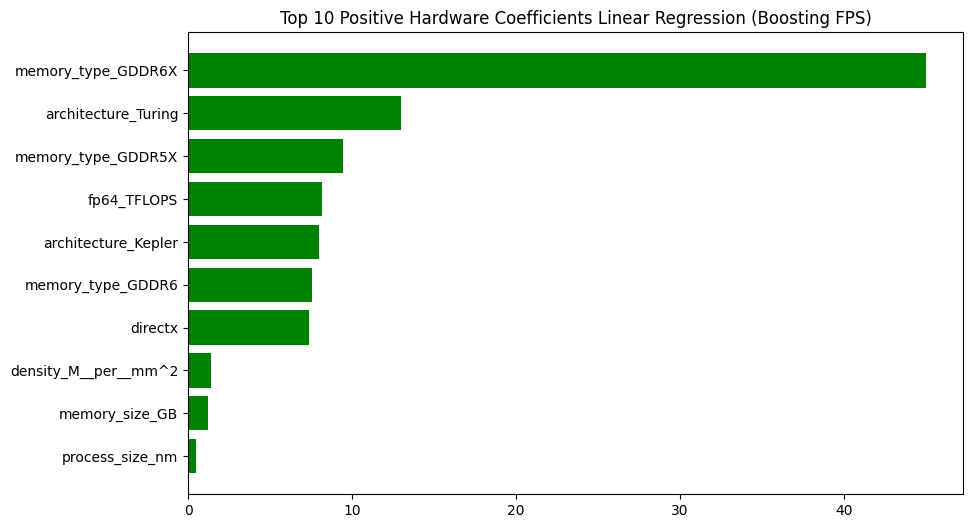

In [35]:
# --- Visualization: Coefficients ---
plt.figure(figsize=(10,6))
plt.barh(top_pos_hw_lr["Feature"], top_pos_hw_lr["Coefficient"], color="green")
plt.title("Top 10 Positive Hardware Coefficients Linear Regression (Boosting FPS)")
plt.gca().invert_yaxis()
plt.show()

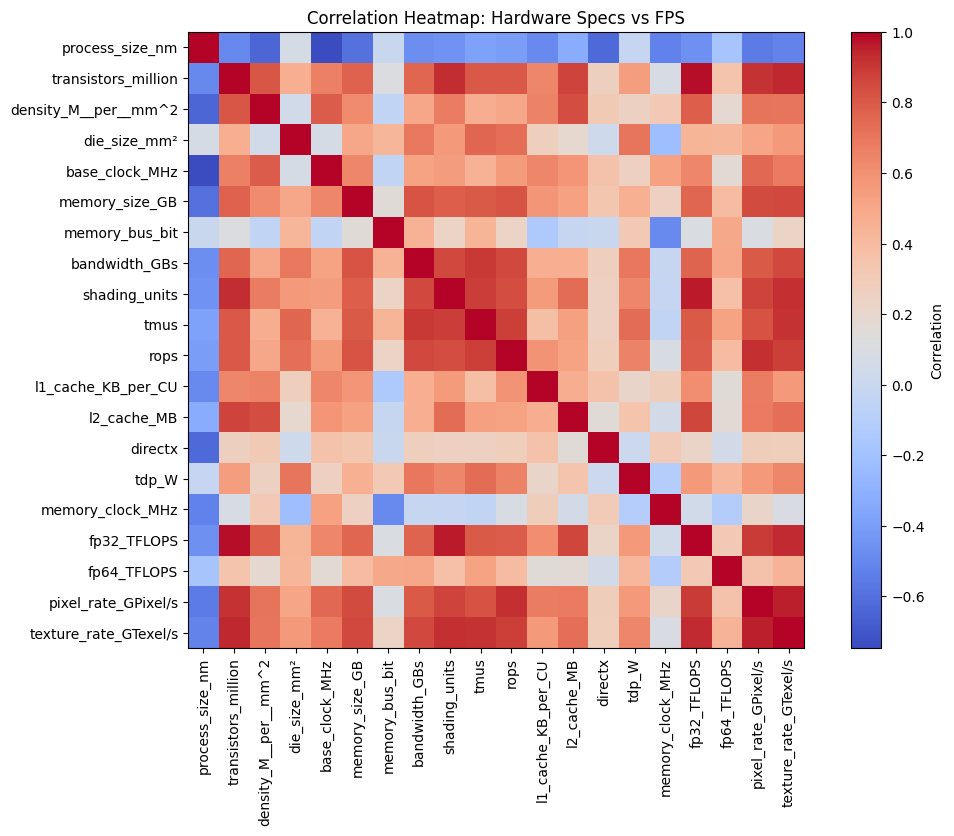

,Feature,Coefficient
29,memory_type_GDDR6X,45.000319
25,architecture_Turing,12.975870
27,memory_type_GDDR5X,9.461606
17,fp64_TFLOPS,8.193332
22,architecture_Kepler,7.976848
28,memory_type_GDDR6,7.577327
13,directx,7.388833
2,density_M__per__mm^2,1.401973
5,memory_size_GB,1.228351
0,process_size_nm,0.455556


In [36]:
# --- Visualization: Correlation heatmap ---
corr_hw_lr = gpu_joined[numeric_features].corr()

plt.figure(figsize=(12,8))
plt.imshow(corr_hw_lr, cmap="coolwarm", interpolation="nearest")
plt.colorbar(label="Correlation")
plt.xticks(range(len(corr_hw_lr.columns)), corr_hw_lr.columns, rotation=90)
plt.yticks(range(len(corr_hw_lr.columns)), corr_hw_lr.columns)
plt.title("Correlation Heatmap: Hardware Specs vs FPS")
plt.show()

coeffs_hw_lr

##### ANALYIZE GAME DRIVEN FPS IN ISOLATION (LINEAR REGRESSION)

In [37]:
def analyze_categorical_feature(df, feature, target="Avg_FPS", top_n=25):
    """
    Train regression on a categorical feature (or list of features) 
    and visualize coefficients.
    
    Parameters:
    -----------
    df : DataFrame
        Input dataset.
    feature : str or list
        Column name(s) to analyze.
    target : str
        Target variable (default = "Avg_FPS").
    top_n : int
        Number of top positive/negative coefficients to show.
    """
    # Ensure feature is list
    if isinstance(feature, str):
        feature = [feature]
    
    X = df[feature]
    y = df[target]

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2
    )

    # Preprocessor
    preprocessor = ColumnTransformer(
        transformers=[("cat", OneHotEncoder(handle_unknown="ignore"), feature)]
    )

    # Pipeline
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("regressor", LinearRegression())
    ])

    # Fit model
    pipeline.fit(X_train, y_train)
    r2 = r2_score(y_test, pipeline.predict(X_test))

    # Extract feature names
    ohe = pipeline.named_steps["preprocessor"].named_transformers_["cat"]
    feature_names = ohe.get_feature_names_out(feature)
    feature_names = [name.split("_", 1)[1] for name in feature_names] 
    if len(feature) == 1:
        feature_names = [name.split("_", 1)[1] for name in feature_names]

    # Coefficients
    coeffs = pd.DataFrame({
        "Feature": feature_names,
        "Coefficient": pipeline.named_steps["regressor"].coef_
    }).sort_values(by="Coefficient", ascending=False)

    # Plot positive
    top_pos = coeffs.head(top_n)
    plt.figure(figsize=(10,6))
    plt.barh(top_pos["Feature"], top_pos["Coefficient"], color="green")
    plt.title(f"Top {top_n} Positive Coefficients for {feature}")
    plt.gca().invert_yaxis()
    plt.show()

    # Plot negative
    top_neg = coeffs.tail(top_n)
    plt.figure(figsize=(10,6))
    plt.barh(top_neg["Feature"], top_neg["Coefficient"], color="red")
    plt.title(f"Top {top_n} Negative Coefficients for {feature}")
    plt.gca().invert_yaxis()
    plt.show()

    return r2, coeffs

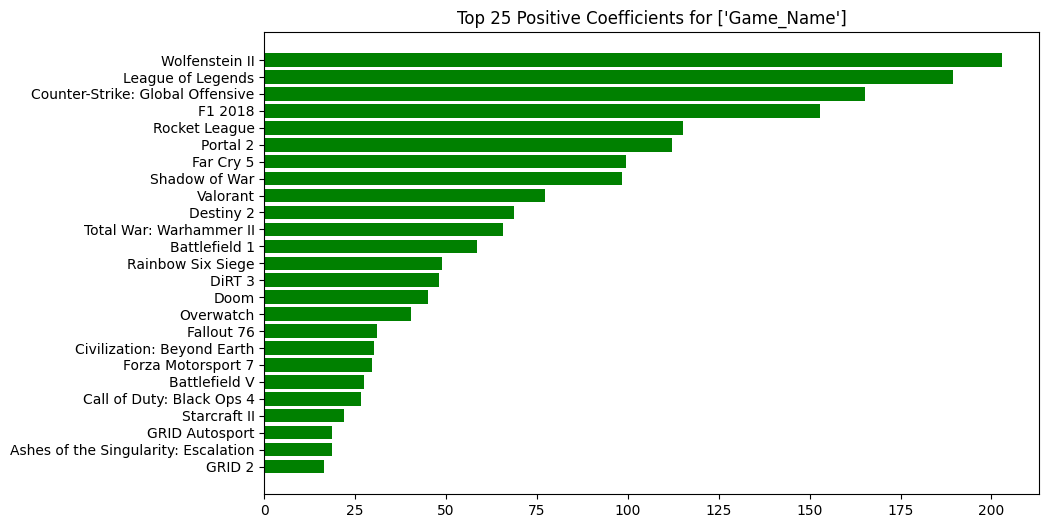

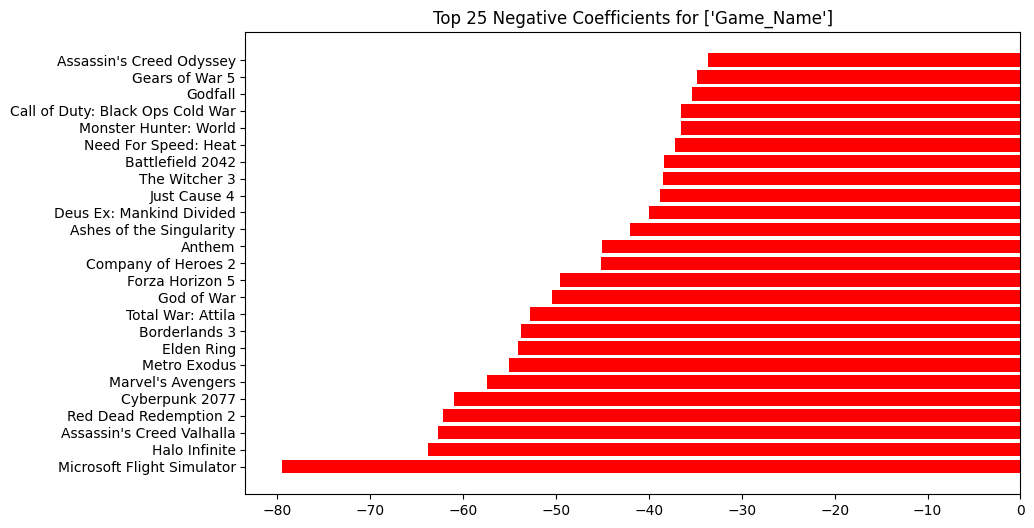

Game-only Linear Regression R²: 0.1858
                              Feature  Coefficient
102                    Wolfenstein II   202.983447
64                  League of Legends   189.425091
21   Counter-Strike: Global Offensive   165.215903
38                            F1 2018   152.824557
84                      Rocket League   115.178408
..                                ...          ...
25                     Cyberpunk 2077   -60.988544
81              Red Dead Redemption 2   -62.196056
6           Assassin's Creed Valhalla   -62.649413
59                      Halo Infinite   -63.792428
69         Microsoft Flight Simulator   -79.447742

[104 rows x 2 columns]


In [38]:
# Game-only
r2_game_lr, coeffs_game_lr = analyze_categorical_feature(gpu_joined, "Game_Name")
print(f"Game-only Linear Regression R²: {r2_game_lr:.4f}")
print(coeffs_game_lr)

##### GENERIC LINEAR REGRESSION MODEL (ALL FEATURES)

In [39]:
numeric_features_final = gpu_joined.select_dtypes(include=["float64"]).drop(columns=["Avg_FPS"]).columns.tolist()
categorical_features = ["Resolution", "Setting", "memory_type", "architecture"]

X = gpu_joined[numeric_features_final + categorical_features]
y = gpu_joined["Avg_FPS"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features_final),
        ("cat", OneHotEncoder(handle_unknown="ignore"), hardware_categorical_features + software_features)
    ]
)

# Pipeline
pipeline_baseline = Pipeline(steps=[("preprocessor", preprocessor),
                           ("regressor", LinearRegression())])

pipeline_baseline.fit(X_train, y_train)
y_pred = pipeline_baseline.predict(X_test)


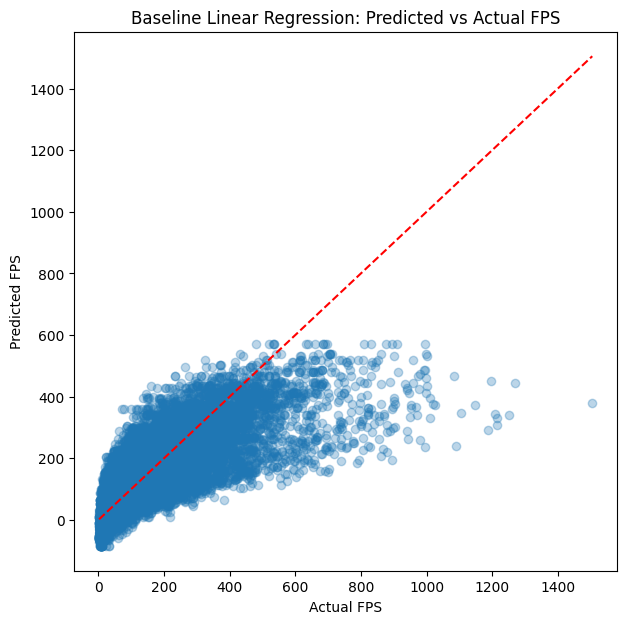

0.6387021692978204

In [40]:
# Evaluate
r2_baseline = r2_score(y_test, y_pred)

# Scatter plot predicted vs actual
plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual FPS")
plt.ylabel("Predicted FPS")
plt.title("Baseline Linear Regression: Predicted vs Actual FPS")
plt.show()

r2_baseline

In [41]:

print("Baseline Linear Regression R²:", r2_score(y_test, y_pred))

Baseline Linear Regression R²: 0.6387021692978204


### BASELINE LINEAR REGRESSION PREDICTING

In [42]:
def predict_fps_batch(pipeline, specs_list: list):
    """
    Predict FPS for a batch of GPU/game/resolution/setting configurations.

    Parameters:
    -----------
    pipeline : trained sklearn pipeline
        The trained baseline model pipeline.
    specs_list : list of dicts
        Each dict contains the required feature values for one configuration.

    Returns:
    --------
    DataFrame : input specs with an added 'Predicted_FPS' column
    """
    df = pd.DataFrame(specs_list)
    df["Predicted_FPS"] = pipeline.predict(df)
    return df

### XG BOOST MODEL

##### VIEW HARDWARE SPECS IN ISOLATION (XGBOOST)

In [43]:
#BASE XGBOOST MODEL FOR HARDWARE ONLY

xg_hw = Pipeline(steps=[
    ('preprocessor', preprocessor_hw),
    ('regressor', XGBRegressor())
])

xg_hw.fit(X_train_hw, y_train_hw)
y_pred_hw_xg = xg_hw.predict(X_test_hw)

r2_hw_xg = r2_score(y_test_hw, y_pred_hw_xg)
print(f"Hardware-only XGBoost R²: {r2_hw_xg:.4f}")

Hardware-only XGBoost R²: 0.4144


In [44]:
xg_model = xg_hw.named_steps['regressor']

ohe_xg = xg_hw.named_steps['preprocessor'].named_transformers_['cat']
cat_features_xg = ohe_xg.get_feature_names_out(hardware_categorical_features)

all_features_names_xg = numeric_features + list(cat_features_xg)

coeffs_hw_xg = pd.DataFrame({
    'Feature' : all_features_names_xg,
    'Coefficient' : xg_model.feature_importances_
}).sort_values(by='Coefficient', ascending=False)

top_pos_hw_xg = coeffs_hw_xg.head(10)
top_neg_hw_xg = coeffs_hw_xg.tail(10)

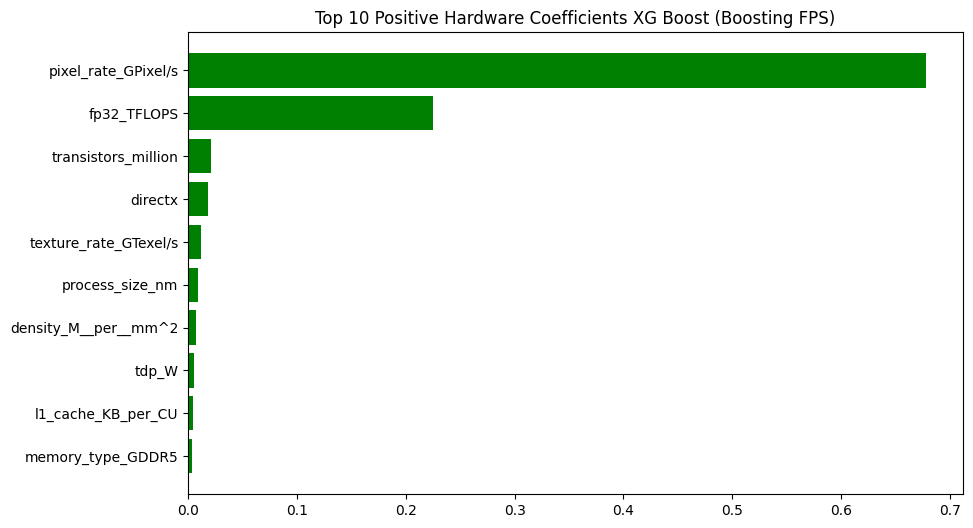

In [45]:
plt.figure(figsize=(10,6))
plt.barh(top_pos_hw_xg['Feature'], top_pos_hw_xg['Coefficient'], color='green')
plt.title('Top 10 Positive Hardware Coefficients XG Boost (Boosting FPS)')
plt.gca().invert_yaxis()
plt.show()

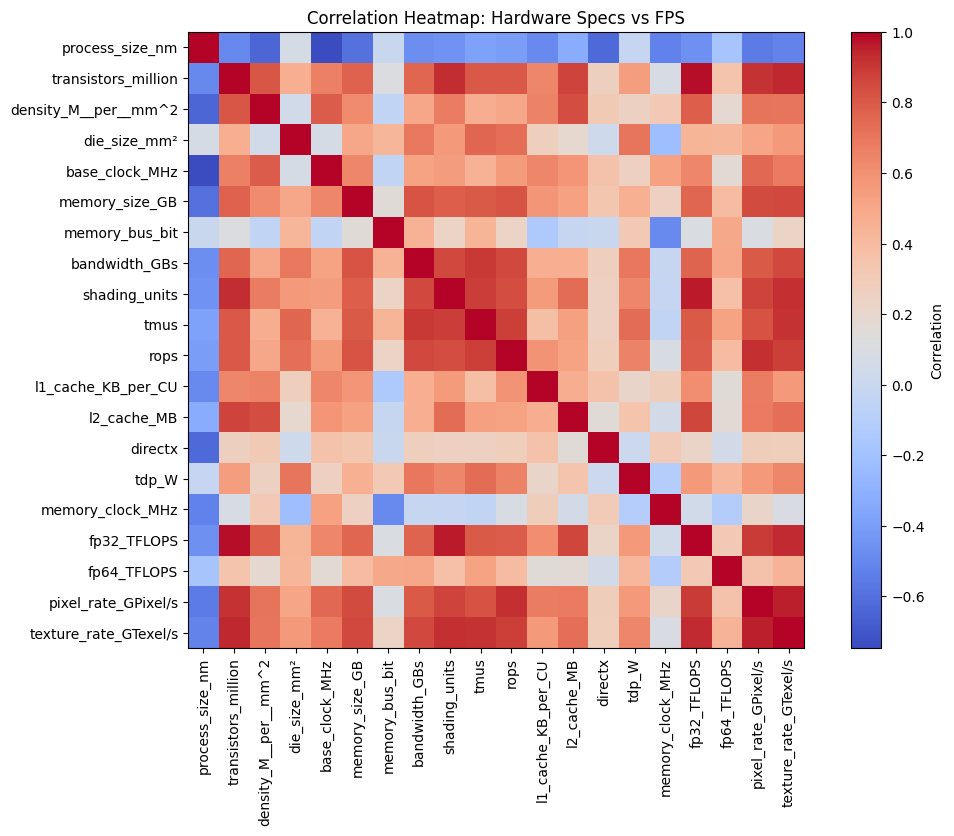

,Feature,Coefficient
18,pixel_rate_GPixel/s,6.782066e-01
16,fp32_TFLOPS,2.254816e-01
1,transistors_million,2.067345e-02
13,directx,1.797785e-02
19,texture_rate_GTexel/s,1.197886e-02
0,process_size_nm,9.458572e-03
2,density_M__per__mm^2,6.835259e-03
14,tdp_W,5.326663e-03
11,l1_cache_KB_per_CU,4.201727e-03
26,memory_type_GDDR5,3.926758e-03


In [46]:
# --- Visualization: Correlation heatmap ---
corr_hw_xg = gpu_joined[numeric_features].corr()

plt.figure(figsize=(12,8))
plt.imshow(corr_hw_xg, cmap="coolwarm", interpolation="nearest")
plt.colorbar(label="Correlation")
plt.xticks(range(len(corr_hw_xg.columns)), corr_hw_xg.columns, rotation=90)
plt.yticks(range(len(corr_hw_xg.columns)), corr_hw_xg.columns)
plt.title("Correlation Heatmap: Hardware Specs vs FPS")
plt.show()

coeffs_hw_xg

##### ANALYIZE GAME DRIVEN FPS IN ISOLATION (XG BOOST)

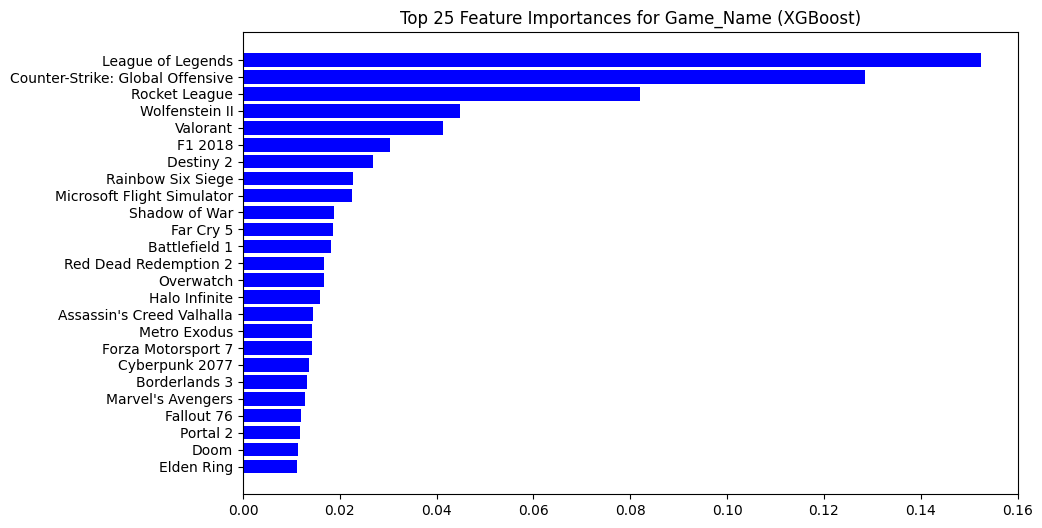

Game-only XGBoost R²: 0.1853


In [47]:
# Feature
feature = ["Game_Name"]
X = gpu_joined[feature]
y = gpu_joined["Avg_FPS"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2
)

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(handle_unknown="ignore"), feature)]
)

# Pipeline with XGBoost
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", XGBRegressor(
        n_estimators=300, learning_rate=0.05, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, n_jobs=-1
    ))
])

# Fit model
pipeline.fit(X_train, y_train)
r2 = r2_score(y_test, pipeline.predict(X_test))


# Get feature names
ohe = pipeline.named_steps["preprocessor"].named_transformers_["cat"]
feature_names = ohe.get_feature_names_out(feature)
feature_names = [name.split("_", 1)[1] for name in feature_names] 
if len(feature) == 1:
    feature_names = [name.split("_", 1)[1] for name in feature_names]

# Get importances
importances = pipeline.named_steps["regressor"].feature_importances_

coeffs = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Plot top 25
top_n = 25
top_pos = coeffs.head(top_n)
plt.figure(figsize=(10,6))
plt.barh(top_pos["Feature"], top_pos["Importance"], color="blue")
plt.title(f"Top {top_n} Feature Importances for Game_Name (XGBoost)")
plt.gca().invert_yaxis()
plt.show()

coeffs.head(10)
print(f"Game-only XGBoost R²: {r2:.4f}")

##### XG BOOST MODEL (ALL FEATURES)

In [48]:
numeric_features_final = gpu_joined.select_dtypes(include=["float64"]).drop(columns=["Avg_FPS"]).columns.tolist()
categorical_features = ["Resolution", "Setting", "memory_type", "architecture"]

X = gpu_joined[numeric_features_final + categorical_features]
y = gpu_joined["Avg_FPS"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features_final),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

# XGBoost pipeline
xgb_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", XGBRegressor())
])

# Fit and evaluate
xgb_pipeline.fit(X_train, y_train)
y_pred = xgb_pipeline.predict(X_test)

print("XGBoost R²:", r2_score(y_test, y_pred))

XGBoost R²: 0.7054926766523724


##### XG Boost Randomized CV

In [49]:
xgb_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", XGBRegressor(
        objective="reg:squarederror",
        tree_method="hist"
    ))
])

# -----------------------------
# 4. Hyperparameter distributions
# -----------------------------
param_dist = {
    # Core boosting parameters
    "regressor__n_estimators": randint(300, 1200),     # more trees → better performance, but slower
    "regressor__learning_rate": uniform(0.01, 0.3),    # extend to 0.3 (common sweet spot with lower trees)
    "regressor__max_depth": randint(2, 12),            # allow very shallow to deeper trees
    "regressor__min_child_weight": randint(1, 15),     # stricter leaf constraints → reduce overfitting

    # Subsampling parameters
    "regressor__subsample": uniform(0.5, 0.5),         # between 0.5–1.0 → prevent overfitting
    "regressor__colsample_bytree": uniform(0.5, 0.5),  # feature sampling 50–100%

    # Regularization parameters
    "regressor__reg_alpha": uniform(0, 5),             # widen range for L1
    "regressor__reg_lambda": uniform(0, 20),           # widen range for L2

    # Additional useful knobs
    "regressor__gamma": uniform(0, 5),                 # min loss reduction for splits → controls complexity
    "regressor__max_delta_step": randint(0, 5),        # helps with imbalanced data (small values usually fine)
    "regressor__scale_pos_weight": uniform(0.5, 2),    # useful if classes/targets are imbalanced
}


# -----------------------------
# 5. Randomized Search
# -----------------------------
random_search = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=param_dist,
    n_iter=10,        # start small
    scoring="r2",
    cv=5,             # fewer folds for testing
    n_jobs=1
)

# -----------------------------
# 6. Fit & Evaluate
# -----------------------------
random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best CV R²:", random_search.best_score_)

# Evaluate on test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Test R²:", r2_score(y_test, y_pred))

Best Parameters: {'regressor__colsample_bytree': np.float64(0.6727503988666796), 'regressor__gamma': np.float64(4.714533659123498), 'regressor__learning_rate': np.float64(0.07794959990707148), 'regressor__max_delta_step': 0, 'regressor__max_depth': 2, 'regressor__min_child_weight': 5, 'regressor__n_estimators': 1005, 'regressor__reg_alpha': np.float64(4.575301542784358), 'regressor__reg_lambda': np.float64(7.452676410088078), 'regressor__scale_pos_weight': np.float64(1.4410783123616633), 'regressor__subsample': np.float64(0.8489580138192474)}
Best CV R²: 0.6979407644180027
Test R²: 0.7069269304797505


 99%|===================| 31561/31752 [01:53<00:00]        

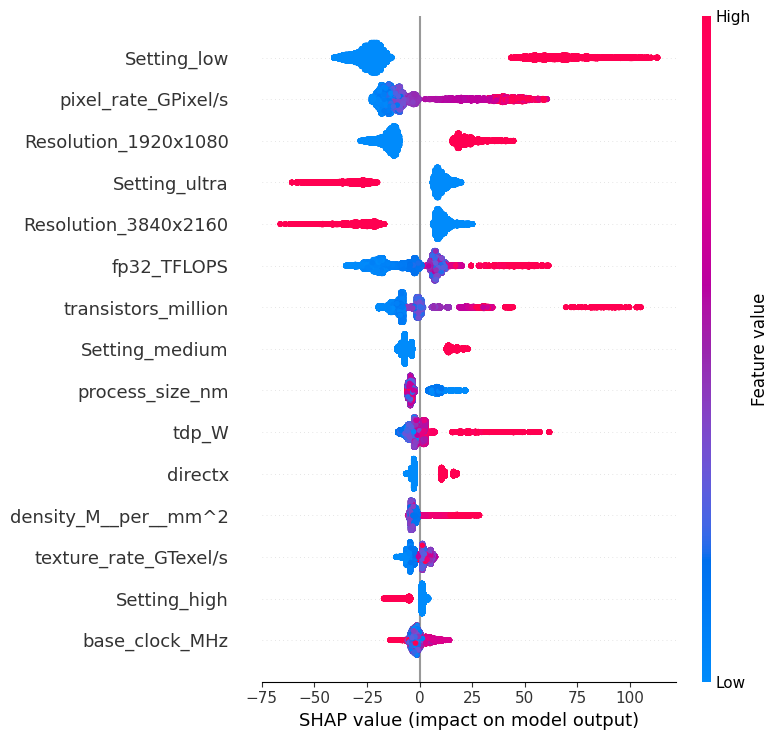

In [50]:
fitted_pipeline = random_search.best_estimator_

# Extract fitted regressor
xgb_reg = fitted_pipeline.named_steps["regressor"]

# Get OHE fitted inside the pipeline
ohe = fitted_pipeline.named_steps["preprocessor"].named_transformers_["cat"]
cat_features = ohe.get_feature_names_out(categorical_features)

# Full feature names
feature_names = numeric_features_final + list(cat_features)

# Now you can safely access importances
importances = xgb_reg.feature_importances_
feat_imp = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# # Plot Top 20
# plt.figure(figsize=(10,6))
# plt.barh(feat_imp.head(20)["Feature"], feat_imp.head(20)["Importance"])
# plt.gca().invert_yaxis()
# plt.title("Top 20 Feature Importances (XGBoost)")
# plt.show()

# -----------------------------
# 3. SHAP Values
# -----------------------------
# Transform data through preprocessor
X_train_trans = xgb_pipeline.named_steps["preprocessor"].transform(X_train)
X_test_trans = xgb_pipeline.named_steps["preprocessor"].transform(X_test)

# SHAP explainer (tree-based for speed)
explainer = shap.TreeExplainer(xgb_reg, X_train_trans, feature_names=feature_names)
shap_values = explainer(X_test_trans)

# SHAP summary plot
shap.summary_plot(shap_values, features=X_test_trans, feature_names=feature_names, max_display=15)

In [51]:
np.shape(shap_values.values)

(31752, 40)

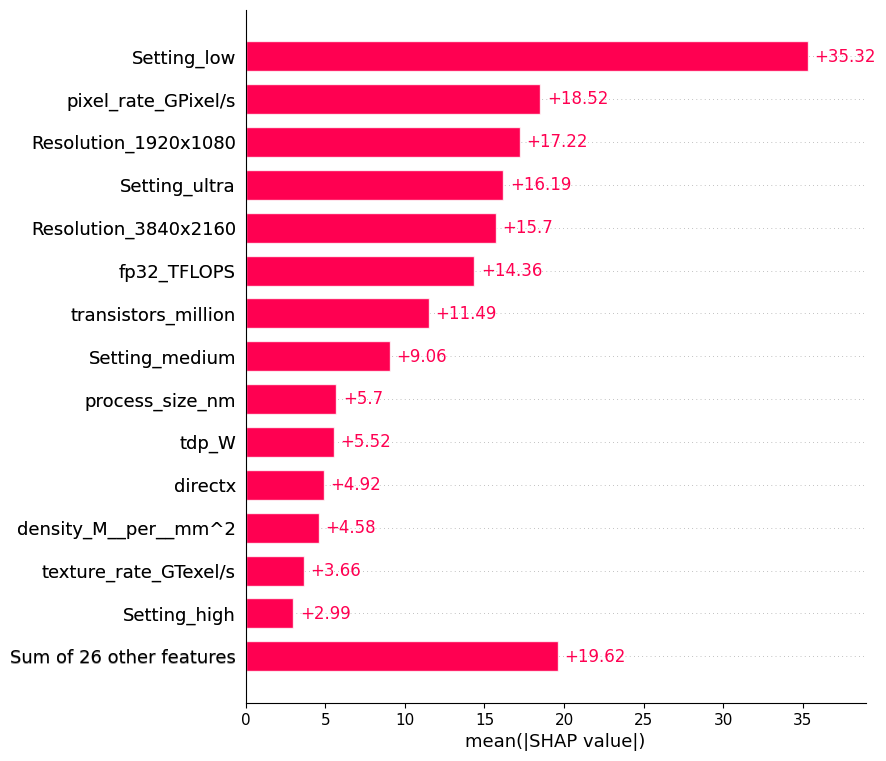

In [52]:
shap.plots.bar(shap_values, max_display=15)

In [53]:
hardware_features = gpu_joined.select_dtypes(include=["float64"]).columns.tolist()

shap_importance = pd.DataFrame({
    "Feature": feature_names,
    "MeanAbsSHAP": np.abs(shap_values.values).mean(axis=0)
})

top_hw = (
    shap_importance[shap_importance["Feature"].isin(hardware_features)]
    .sort_values("MeanAbsSHAP", ascending=False)
    .head(10)   # top 5 hardware features
)["Feature"].tolist()

In [54]:
shap_df = pd.DataFrame(shap_values.values, 
                       columns=[f"{c}_SHAP" for c in feature_names], 
                       index=X_test.index)

X_test_with_shap = pd.concat([X_test.reset_index(drop=True), 
                              shap_df.reset_index(drop=True)], axis=1)

# 2. Group by Resolution and Setting
# Mean absolute SHAP (importance) is usually more interpretable
grouped_res = X_test_with_shap.groupby("Resolution")[[f"{f}_SHAP" for f in top_hw]].mean()
grouped_set = X_test_with_shap.groupby("Setting")[[f"{f}_SHAP" for f in top_hw]].mean()


display("🔎 Average SHAP values by Resolution:\n", grouped_res)
display("\n🔎 Average SHAP values by Setting:\n", grouped_set)


'🔎 Average SHAP values by Resolution:\n'

,pixel_rate_GPixel/s_SHAP,fp32_TFLOPS_SHAP,transistors_million_SHAP,process_size_nm_SHAP,tdp_W_SHAP,directx_SHAP,density_M__per__mm^2_SHAP,texture_rate_GTexel/s_SHAP,base_clock_MHz_SHAP,die_size_mm²_SHAP
Resolution,,,,,,,,,,
1920x1080,-3.215743,-3.532012,-1.927479,-0.733105,0.278819,-0.370194,-1.244955,-0.541210,-0.648986,0.206938
2560x1440,-2.953870,-2.765734,-1.986251,-0.525155,0.314973,-0.306424,-1.103591,-0.380594,-0.436422,0.187154
3440x1440,5.470849,3.621242,4.032865,1.292587,3.510750,1.242416,0.756920,0.899992,0.169360,-0.546672
3840x2160,-1.177460,-1.451339,-1.021060,-0.134678,0.355828,0.129967,-0.652876,-0.153346,-0.395522,0.083243


'\n🔎 Average SHAP values by Setting:\n'

,pixel_rate_GPixel/s_SHAP,fp32_TFLOPS_SHAP,transistors_million_SHAP,process_size_nm_SHAP,tdp_W_SHAP,directx_SHAP,density_M__per__mm^2_SHAP,texture_rate_GTexel/s_SHAP,base_clock_MHz_SHAP,die_size_mm²_SHAP
Setting,,,,,,,,,,
high,-1.402070,-1.776942,-0.970255,-0.246903,0.571474,-0.019642,-0.677484,-0.137451,-0.344811,0.099070
low,-1.408618,-1.796652,-0.840005,-0.158720,1.051024,0.101730,-0.743123,-0.209914,-0.613394,0.007929
medium,-1.427039,-1.771045,-0.915911,-0.245964,0.782612,-0.021566,-0.830926,-0.244436,-0.452833,0.081692
ultra,-1.549011,-1.877773,-0.938041,-0.325000,0.541368,-0.078015,-0.870198,-0.208490,-0.234994,0.085570


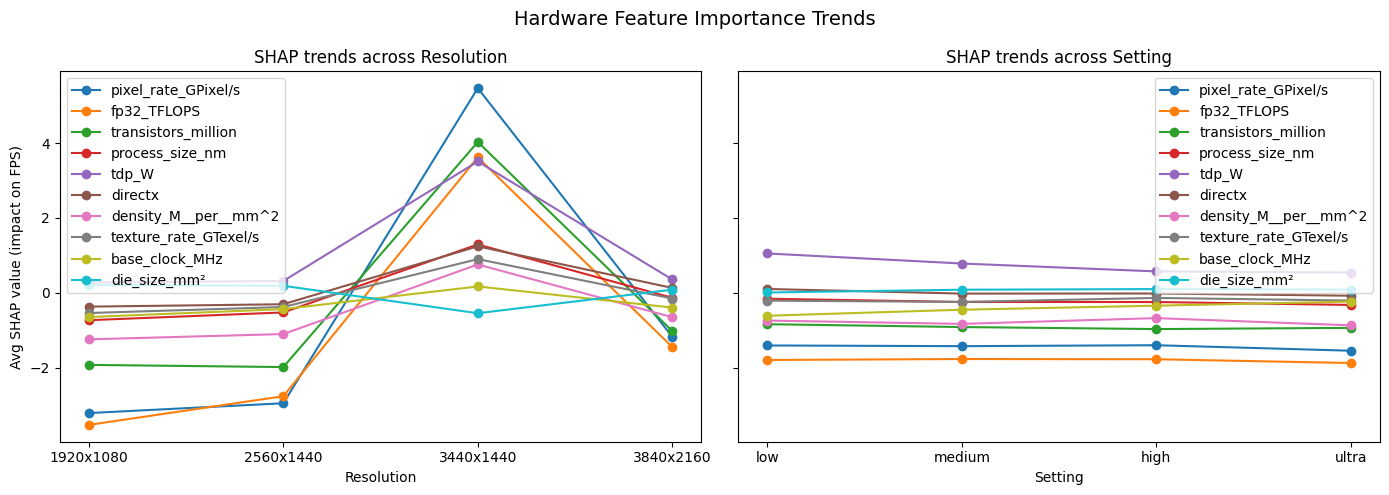

In [55]:
resolution_order = ["1920x1080", "2560x1440", "3440x1440", "3840x2160"]
setting_order = ["low", "medium", "high", "ultra"]

grouped_res = grouped_res.reindex(resolution_order)
grouped_set = grouped_set.reindex(setting_order)

# -----------------------------
# 2. Plot line trends
# -----------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Resolution trends
for col in grouped_res.columns:
    axes[0].plot(grouped_res.index, grouped_res[col], marker="o", label=col.replace("_SHAP",""))
axes[0].set_title("SHAP trends across Resolution")
axes[0].set_xlabel("Resolution")
axes[0].set_ylabel("Avg SHAP value (impact on FPS)")
axes[0].legend()

# Setting trends
for col in grouped_set.columns:
    axes[1].plot(grouped_set.index, grouped_set[col], marker="o", label=col.replace("_SHAP",""))
axes[1].set_title("SHAP trends across Setting")
axes[1].set_xlabel("Setting")
axes[1].legend()

plt.suptitle("Hardware Feature Importance Trends", fontsize=14)
plt.tight_layout()
plt.show()

🔎 Mean Absolute SHAP values by Resolution:



,pixel_rate_GPixel/s_SHAP,fp32_TFLOPS_SHAP,transistors_million_SHAP,process_size_nm_SHAP,tdp_W_SHAP,directx_SHAP,density_M__per__mm^2_SHAP,texture_rate_GTexel/s_SHAP,base_clock_MHz_SHAP,die_size_mm²_SHAP
Resolution,,,,,,,,,,
1920x1080,20.380281,15.781601,11.341729,6.864304,5.851756,5.139138,5.070421,3.713819,3.209013,2.037994
2560x1440,17.884070,14.208411,11.024622,5.582010,5.577534,4.563337,4.422576,3.682237,2.731893,1.992068
3440x1440,21.285629,15.236349,13.684786,6.257231,6.324886,5.494222,5.592982,3.619386,3.002333,2.298804
3840x2160,15.729954,12.473776,11.103787,4.242512,4.686689,4.766579,3.697580,3.580955,2.446362,2.058583



🔎 Mean Absolute SHAP values by Setting:



,pixel_rate_GPixel/s_SHAP,fp32_TFLOPS_SHAP,transistors_million_SHAP,process_size_nm_SHAP,tdp_W_SHAP,directx_SHAP,density_M__per__mm^2_SHAP,texture_rate_GTexel/s_SHAP,base_clock_MHz_SHAP,die_size_mm²_SHAP
Setting,,,,,,,,,,
low,21.631012,17.303488,14.154638,6.287601,6.497738,6.610158,4.910892,4.573801,4.026297,1.996500
medium,18.397746,14.596341,11.332744,6.053870,5.558868,4.384578,5.152609,3.481486,3.000226,1.913053
high,17.472883,13.637303,10.576777,5.780611,5.341915,4.380265,4.038094,3.345027,2.465336,2.105572
ultra,16.599566,11.940342,9.936013,4.707988,4.696846,4.302253,4.227276,3.232485,1.872276,2.239162


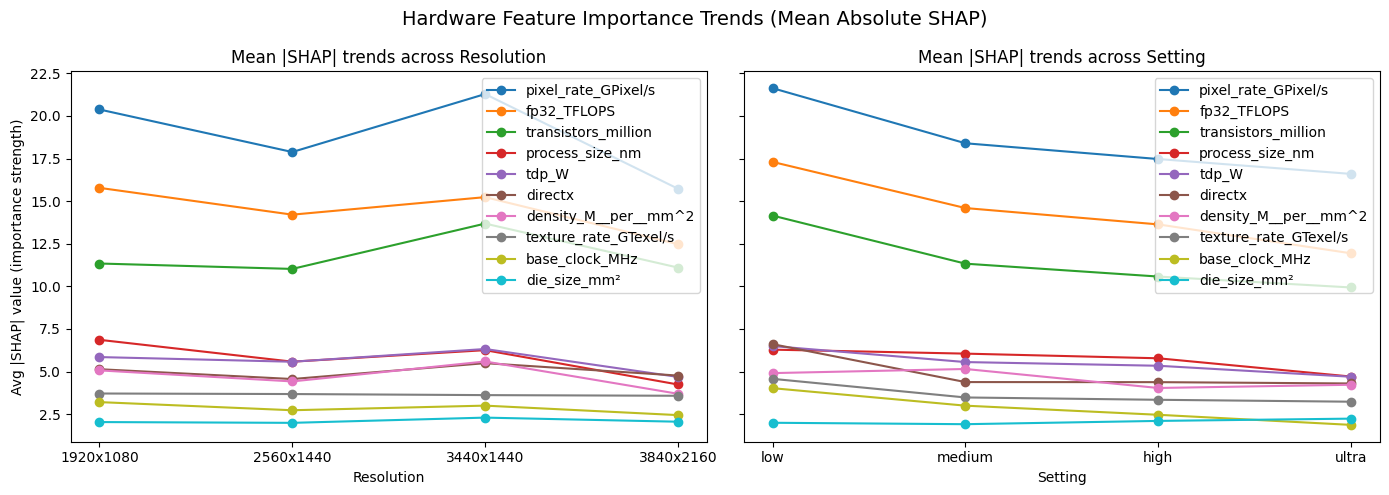

In [56]:
# -----------------------------
# 1. Compute mean absolute SHAP
# -----------------------------
grouped_res_abs = (
    X_test_with_shap
    .groupby("Resolution")[[f"{f}_SHAP" for f in top_hw]]
    .apply(lambda df: np.abs(df).mean())
)

grouped_set_abs = (
    X_test_with_shap
    .groupby("Setting")[[f"{f}_SHAP" for f in top_hw]]
    .apply(lambda df: np.abs(df).mean())
)

# Ensure categories are ordered
resolution_order = ["1920x1080", "2560x1440", "3440x1440", "3840x2160"]
setting_order = ["low", "medium", "high", "ultra"]

grouped_res_abs = grouped_res_abs.reindex(resolution_order)
grouped_set_abs = grouped_set_abs.reindex(setting_order)

# -----------------------------
# 2. Display tables
# -----------------------------
print("🔎 Mean Absolute SHAP values by Resolution:\n")
display(grouped_res_abs)

print("\n🔎 Mean Absolute SHAP values by Setting:\n")
display(grouped_set_abs)

# -----------------------------
# 3. Plot line trends
# -----------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Resolution trends
for col in grouped_res_abs.columns:
    axes[0].plot(grouped_res_abs.index, grouped_res_abs[col], marker="o", label=col.replace("_SHAP",""))
axes[0].set_title("Mean |SHAP| trends across Resolution")
axes[0].set_xlabel("Resolution")
axes[0].set_ylabel("Avg |SHAP| value (importance strength)")
axes[0].legend()

# Setting trends
for col in grouped_set_abs.columns:
    axes[1].plot(grouped_set_abs.index, grouped_set_abs[col], marker="o", label=col.replace("_SHAP",""))
axes[1].set_title("Mean |SHAP| trends across Setting")
axes[1].set_xlabel("Setting")
axes[1].legend()

plt.suptitle("Hardware Feature Importance Trends (Mean Absolute SHAP)", fontsize=14)
plt.tight_layout()
plt.show()

In [57]:
feature_order = [
    "GPU_Name",
    "architecture",
    "process_size_nm",
    "transistors_million",
    "density_M__per__mm^2",
    "die_size_mm²",
    "base_clock_MHz",
    "memory_size_GB",
    "memory_type",
    "memory_bus_bit",
    "bandwidth_GBs",
    "shading_units",
    "tmus",
    "rops",
    "l1_cache_KB_per_CU",
    "l2_cache_MB",
    "directx",
    "tdp_W",
    "memory_clock_MHz",
    "fp32_TFLOPS",
    "fp64_TFLOPS",
    "pixel_rate_GPixel/s",
    "texture_rate_GTexel/s",
    "Game_Name",
    "Avg_FPS",
    "Setting",
    "Resolution"
]

In [58]:
def parse_spec_string(spec_string: str, feature_order: list) -> dict:
    """
    Convert a CSV-like GPU spec string into a dict for prediction.

    Parameters
    ----------
    spec_string : str
        Comma-separated string of feature values.
    feature_order : list
        List of feature names in the same order as the string.

    Returns
    -------
    dict : Parsed dictionary (ignores Game_Name and Avg_FPS if present).
    """
    values = spec_string.split(",")
    spec_dict = dict(zip(feature_order, values))

    # Drop fields you don't want as predictors
    spec_dict.pop("GPU_Name", None)
    spec_dict.pop("Game_Name", None)
    spec_dict.pop("Avg_FPS", None)

    # Convert numeric fields from str → float
    for key in spec_dict:
        try:
            spec_dict[key] = float(spec_dict[key])
        except ValueError:
            pass  # keep as string if not convertible

    return spec_dict

In [59]:
spec_string = "AMD Radeon 530 Mobile,Other,28.0,1550.0,12.4,125.0,730.0,2.0,Other,64.0,14.4,384.0,24.0,8.0,16.0,0.125,12.0,50.0,900.0,0.78,0.05,8.168,24.5,Assassin's Creed Origins,7.0,ultra,2560x1440"

parsed_dict = parse_spec_string(spec_string, feature_order)

batch_specs = [parsed_dict]
batch_predictions = predict_fps_batch(pipeline_baseline, batch_specs)

display(batch_predictions)

,architecture,process_size_nm,transistors_million,density_M__per__mm^2,die_size_mm²,base_clock_MHz,memory_size_GB,memory_type,memory_bus_bit,bandwidth_GBs,...,directx,tdp_W,memory_clock_MHz,fp32_TFLOPS,fp64_TFLOPS,pixel_rate_GPixel/s,texture_rate_GTexel/s,Setting,Resolution,Predicted_FPS
0,Other,28.0,1550.0,12.4,125.0,730.0,2.0,Other,64.0,14.4,...,12.0,50.0,900.0,0.78,0.05,8.168,24.5,ultra,2560x1440,-21.201969


In [60]:
spec_string = "AMD Radeon 530 Mobile,Other,28.0,1550.0,12.4,125.0,730.0,2.0,Other,64.0,14.4,384.0,24.0,8.0,16.0,0.125,12.0,50.0,900.0,0.78,0.05,8.168,24.5,Assassin's Creed Origins,7.0,ultra,2560x1440"

parsed_dict = parse_spec_string(spec_string, feature_order)

batch_specs = [parsed_dict]
batch_predictions = predict_fps_batch(fitted_pipeline, batch_specs)

display(batch_predictions)

,architecture,process_size_nm,transistors_million,density_M__per__mm^2,die_size_mm²,base_clock_MHz,memory_size_GB,memory_type,memory_bus_bit,bandwidth_GBs,...,directx,tdp_W,memory_clock_MHz,fp32_TFLOPS,fp64_TFLOPS,pixel_rate_GPixel/s,texture_rate_GTexel/s,Setting,Resolution,Predicted_FPS
0,Other,28.0,1550.0,12.4,125.0,730.0,2.0,Other,64.0,14.4,...,12.0,50.0,900.0,0.78,0.05,8.168,24.5,ultra,2560x1440,1.516091
